# Class specific feature analysis

In [2]:
# load the model information and scores (this function is also found in xgboost_reimplementation)
import pickle
import joblib
def read_models():
        
    models = []
    for i in range(4):
        model = joblib.load('../figs_xgboost/xgboost_models/' + str(i) + '.pkl')
        models.append(model)
        
    # now load the other arrays
    test_indices_list = pickle.load(open('../figs_xgboost/test_indices_list.json', 'rb'))
    best_params = pickle.load(open('../figs_xgboost/best_params.json', 'rb'))
    bayes_trials_hist = pickle.load(open('../figs_xgboost/bayes_trials_hist.json', 'rb'))
    
    return(models, test_indices_list, best_params, bayes_trials_hist)


models, test_indices_list, best_params, bayes_trials_hist = read_models()


/home/in268/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [111]:

model_num = 0
m = models[model_num]

m.n_estimators
m.n_classes_
xgboost_dataframe = m.get_booster().trees_to_dataframe()
170*5
xgboost_dataframe

170

5

850

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f58151,-0.659328,0-1,0-2,0-1,159.373077,143.884155
1,0,1,0-1,f155358,0.518679,0-3,0-4,0-3,14.549236,110.655296
2,0,2,0-2,f60592,-1.552435,0-5,0-6,0-6,41.143494,33.228855
3,0,3,0-3,f87866,1.905957,0-7,0-8,0-7,2.427425,107.508736
4,0,4,0-4,f13,-2.528847,0-9,0-10,0-9,1.658674,3.146562
...,...,...,...,...,...,...,...,...,...,...
4445,847,0,847-0,f38752,-5.912050,847-1,847-2,847-1,0.152763,2.307935
4446,847,1,847-1,Leaf,NaN,NaN,NaN,NaN,0.019855,1.115088
4447,847,2,847-2,Leaf,NaN,NaN,NaN,NaN,-0.017821,1.192848
4448,848,0,848-0,Leaf,NaN,NaN,NaN,NaN,-0.002931,1.297037


class
0    116
1    416
2    386
3    159
4    446
Name: Feature, dtype: int64

class
0    {f1510, f9875, f80999, f2357, f32482, f48625, ...
1    {f19418, f133508, f120076, f45448, f865, f4614...
2    {f96485, f53318, f8681, f59533, f155250, f4128...
3    {f1510, f9875, f150875, f24849, f93204, f5071,...
4    {f144394, f111206, f14530, f44783, f25898, f60...
Name: Feature, dtype: object

id
0     1     2     3     4             
True  False False True  False    f1510
                        False    f9875
                  False False   f80999
                        False    f2357
                        False   f32482
...                                ...
False False False False True    f96939
                        True   f117214
                        True    f64354
                        True    f98016
                        True    f46752

[1490 rows x 1 columns]

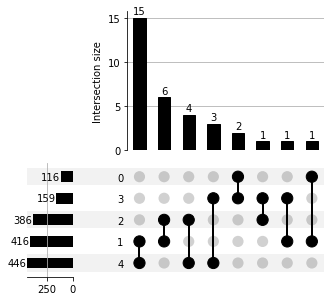

In [112]:
features_per_tree = xgboost_dataframe[['Tree', 'Feature']].groupby('Tree')['Feature'].apply(list)
features_per_tree = features_per_tree.apply(lambda l: [i for i in l if i!='Leaf'])
import pandas as pd
num_classes = 5
features_per_tree = pd.DataFrame({'Feature':features_per_tree, 'class':features_per_tree.index % num_classes})
# apparently the trees cycle through each class, see https://github.com/dmlc/xgboost/issues/1746 and https://stackoverflow.com/questions/62629149/interpreting-leaf-values-of-xgboost-trees-for-multiclass-classification-problem
features_per_class = features_per_tree.groupby('class')['Feature'].apply(list)
features_per_class = features_per_class.apply(lambda l: [j for i in l for j in i]) # flatten
features_per_class = features_per_class.apply(set)# make sure unique
features_per_class.apply(len)
features_per_class
# need a 5-way upset plot (shows overlap between sets)
from upsetplot import from_contents
to_plot = from_contents({'0': features_per_class[0], '1': features_per_class[1], '2': features_per_class[2], '3':features_per_class[3], '4':features_per_class[4]})
to_plot

from upsetplot import UpSet
plt = UpSet(to_plot, subset_size='count', max_subset_size=100, sort_by='cardinality', show_counts=True).plot() # setting max_subset_size means single sets aren't plotted



### Checking these features per class are correct

In [113]:
# check the model features are the same as the union of the features for all classes:
union = set()
for f in features_per_class:
    union = union.union(f)
len(union)
sum(m.feature_importances_ > 0)
assert len(union) == sum(m.feature_importances_ > 0)

1490

1490

In [216]:
features_to_genes = pd.read_csv('../figs_xgboost/xgboost_models/' + str(model_num) + '_features_mapped_to_genes.csv')
all_features = pd.read_csv('../data/training_testing_maxgap_50_newdata_processed_probe_names.csv')
def get_features_info(feature_names):
    features_as_indices = [int(f.replace('f', '')) for f in feature_names]

    class_features_info = all_features.iloc[features_as_indices]
    class_features_info.loc[:,'seqnames'] = class_features_info['seqnames'].str.replace('chr', '').astype(int)

    class_features_info = pd.merge(class_features_info, features_to_genes, how='inner', on=['seqnames', 'start']) # adding in gene names

    return(class_features_info)


{'NDUFA4L2', 'PVT1'}

False

### Get the features for each class and save

In [319]:
import pandas as pd

def get_features_per_class(model_num):
    m = models[model_num]
    xgboost_dataframe = m.get_booster().trees_to_dataframe()

    features_per_tree = xgboost_dataframe[['Tree', 'Feature']].groupby('Tree')['Feature'].apply(list)
    features_per_tree = features_per_tree.apply(lambda l: [i for i in l if i!='Leaf'])

    num_classes = 5
    features_per_tree = pd.DataFrame({'Feature':features_per_tree, 'class':features_per_tree.index % num_classes}) # the trees cycle through each class
    features_per_class = features_per_tree.groupby('class')['Feature'].apply(list)
    features_per_class = features_per_class.apply(lambda l: [j for i in l for j in i]) # flatten
    features_per_class = features_per_class.apply(set)# make sure unique
    
    return(features_per_class)

features_per_class_df = pd.DataFrame()
for model_num in range(4):
    features = get_features_per_class(model_num)
    to_add = pd.DataFrame(features)
    to_add['model'] = model_num
    to_add['class'] = to_add.index
    features_per_class_df = features_per_class_df.append(to_add)
features_per_class_df = features_per_class_df.reset_index(drop=True)
features_per_class_df

# and save
features_per_class_df.to_csv('features_per_class/features_per_class_df', sep='\t')


,Feature,model,class
0,"{f1510, f9875, f80999, f2357, f32482, f48625, ...",0,0
1,"{f19418, f133508, f120076, f45448, f865, f4614...",0,1
2,"{f96485, f53318, f8681, f59533, f155250, f4128...",0,2
3,"{f1510, f9875, f150875, f24849, f93204, f5071,...",0,3
4,"{f144394, f111206, f14530, f44783, f25898, f60...",0,4
5,"{f140606, f157765, f114567, f2357, f48625, f13...",1,0
6,"{f63640, f131448, f79802, f10201, f138, f85927...",1,1
7,"{f46923, f82263, f96485, f8784, f55755, f33684...",1,2
8,"{f48402, f139162, f31366, f94128, f6755, f1524...",1,3
9,"{f50327, f82263, f79629, f45979, f143533, f512...",1,4


In [387]:
# also get features per class for all models together in one list
features_per_class_df_models_combined = pd.DataFrame()

c= 0
for c in range(5):
    vals = features_per_class_df[features_per_class_df['class'] == c]['Feature'].values
    to_add = pd.DataFrame({'Feature':[set().union(*vals)], 'class': c})
    features_per_class_df_models_combined = features_per_class_df_models_combined.append(to_add)

features_per_class_df_models_combined.index = features_per_class_df_models_combined['class']
features_per_class_df_models_combined.to_csv('features_per_class/features_per_class_df_models_combined', sep='\t')
features_per_class_df_models_combined

,Feature,class
class,,
0,"{f140606, f1510, f9875, f88543, f151347, f8099...",0
1,"{f63640, f148339, f142300, f133508, f79802, f1...",1
2,"{f96485, f8784, f28528, f55755, f155250, f1029...",2
3,"{f1510, f9875, f48402, f23371, f90131, f148504...",3
4,"{f21251, f79629, f20828, f127301, f33734, f143...",4


In [502]:
len(features_per_class_df_models_combined.loc[0]['Feature'])

349

In [524]:
# and save all features with seqnames and start and probe details (not mapped to genes, so we don't miss out the features that don't map to any genes)

def get_features_info_without_gene_mapping(feature_names):
    features_as_indices = [int(f.replace('f', '')) for f in feature_names]

    class_features_info = all_features.iloc[features_as_indices]
    class_features_info.loc[:,'seqnames'] = class_features_info['seqnames'].str.replace('chr', '').astype(int)

    return(class_features_info)


features_per_class_details = list(map(get_features_info_without_gene_mapping, features_per_class_df_models_combined['Feature']))
features_per_class_details = [features_per_class_details[i].assign(c=i) for i in range(len(features_per_class_details))] # add class (c) column
features_per_class_details = pd.concat(features_per_class_details)

# and save
features_per_class_details.to_csv('features_per_class/features_per_class_df_models_combined_no_gene_info.csv')


/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Now upset plot for features from all models combined

id
0     1     2     3     4             
True  False False False False  f140606
            True  True  False    f1510
            False True  False    f9875
                  False False   f88543
                        False  f151347
...                                ...
False False False False True    f64354
                        True   f134094
                        True    f39671
                        True    f98016
                        True   f101318

[5241 rows x 1 columns]

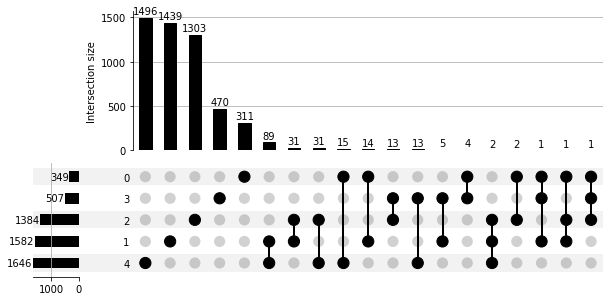

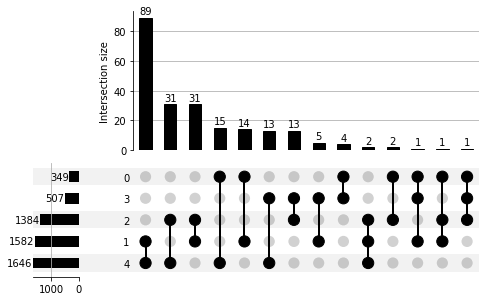

In [365]:
# plot all upset plots:

# need a 5-way upset plot (shows overlap between sets)
from upsetplot import from_contents
to_plot = from_contents({'0': features_per_class_df_models_combined.loc[0]['Feature'], '1': features_per_class_df_models_combined.loc[1]['Feature'], '2': features_per_class_df_models_combined.loc[2]['Feature'], '3':features_per_class_df_models_combined.loc[3]['Feature'], '4':features_per_class_df_models_combined.loc[4]['Feature']})
to_plot

from upsetplot import UpSet

# with single sets:    
plt = UpSet(to_plot, subset_size='count', sort_by='cardinality', show_counts=True).plot() # setting max_subset_size means single sets aren't plotted
# just intersections:
plt = UpSet(to_plot, subset_size='count', sort_by='cardinality', show_counts=True, max_subset_size=100).plot() # setting max_subset_size means single sets aren't plotted



In [367]:
# how large is each class?
features_per_class_df_models_combined['Feature'].apply(len)


class
0     349
1    1582
2    1384
3     507
4    1646
Name: Feature, dtype: int64

### Map to genes

In [435]:
# map to gene lists

# create features_to_genes that contains info about all 4 models
features_to_genes_all_models = pd.DataFrame()
for model_num in range(4):
    features_to_genes = pd.read_csv('../figs_xgboost/xgboost_models/' + str(model_num) + '_features_mapped_to_genes.csv')
    features_to_genes_all_models = features_to_genes_all_models.append(features_to_genes)
features_to_genes_all_models = features_to_genes_all_models.drop('Unnamed: 0', axis=1)
features_to_genes_all_models = features_to_genes_all_models.drop_duplicates()
features_to_genes_all_models = features_to_genes_all_models.reset_index(drop=True)
features_to_genes_all_models


# uses features_to_genes_all_models so we can get feature info for features from all 4 models
def get_features_info_all_models(feature_names):
    features_as_indices = [int(f.replace('f', '')) for f in feature_names]

    class_features_info = all_features.iloc[features_as_indices]
    class_features_info.loc[:,'seqnames'] = class_features_info['seqnames'].str.replace('chr', '').astype(int)
    class_features_info['Feature name'] = feature_names # also save the feature name 

    class_features_info = pd.merge(class_features_info, features_to_genes_all_models, how='inner', on=['seqnames', 'start']) # adding in gene names

    return(class_features_info)


features_mapped_to_genes = pd.DataFrame()
for c in range(5):
    info_df = get_features_info_all_models(features_per_class_df_models_combined.loc[c]['Feature'])
    info_df['class'] = c
    features_mapped_to_genes = features_mapped_to_genes.append(info_df)

# check properties of this df
len(features_mapped_to_genes['gene_name'].dropna().unique()) # should be 4216
len(features_mapped_to_genes['ensembl_gene_id'].dropna().unique()) # should be 5011

# and save
features_mapped_to_genes.to_csv('features_per_class/features_per_class_mapped_to_genes.csv')

features_mapped_to_genes


,seqnames,start,end,width,strand,feature.ranges.start,feature.ranges.end,feature.ranges.width,feature.strand,distance,insideFeature,distanceToSite,ensembl_gene_id,gene_name
0,16,53434200,53434200,1,*,53433977,53491648,57672,+,0,inside,0,ENSG00000103479,RBL2
1,12,123601930,123601930,1,*,123602077,123620943,18867,+,146,upstream,146,ENSG00000111364,DDX55
2,19,39307841,39307841,1,*,39306566,39320863,14298,-,0,inside,0,ENSG00000128011,LRFN1
3,1,1333413,1333413,1,*,1331280,1335314,4035,+,0,inside,0,ENSG00000169962,TAS1R3
4,1,169427468,169427468,1,*,169394870,169460669,65800,-,0,inside,0,ENSG00000117477,CCDC181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,12,6963564,6963564,1,*,6964097,6964191,95,+,532,upstream,532,ENSG00000207708,MIR141
6505,12,6963564,6963564,1,*,6964949,6965382,434,+,1384,upstream,1384,ENSG00000271969,NaN
6506,15,75649235,75649235,1,*,75647912,75662301,14390,+,0,inside,0,ENSG00000173548,SNX33
6507,15,75649235,75649235,1,*,75639085,75648706,9622,-,528,upstream,528,ENSG00000177971,IMP3


/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4216

5011

,seqnames,start,Composite Element REF,End,Feature name,end,width,strand,feature.ranges.start,feature.ranges.end,feature.ranges.width,feature.strand,distance,insideFeature,distanceToSite,ensembl_gene_id,gene_name,class
0,15,72228291,cg24327132,72228292,f140606,72228291,1,*,72199029,72231822,32794,-,0,inside,0,ENSG00000067225,PKM,0
1,16,8712899,cg00220102,8712900,f1510,8712899,1,*,8674596,8784575,109980,+,0,inside,0,ENSG00000183044,ABAT,0
2,22,38872200,cg14498989,38872201,f88543,38872200,1,*,38861422,38872249,10828,-,0,inside,0,ENSG00000183741,CBX6,0
3,1,203488022,cg13371976,203488023,f80999,203488022,1,*,203475806,203491352,15547,+,0,inside,0,ENSG00000188783,PRELP,0
4,12,99155172,cg14195216,99155173,f86547,99155172,1,*,98726457,99984654,1258198,-,0,inside,0,ENSG00000185046,ANKS1B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,1,2088087,cg06176608,2088088,f39671,2088087,1,*,2050411,2185395,134985,+,0,inside,0,ENSG00000067606,PRKCZ,4
1962,2,9951768,cg16227131,9951769,f98016,9951768,1,*,9939088,9950817,11730,-,950,upstream,950,ENSG00000287305,NaN,4
1963,2,9951768,cg16227131,9951769,f98016,9951768,1,*,9951693,10002277,50585,+,0,inside,0,ENSG00000134317,GRHL1,4
1964,18,77108537,cg16762684,77108538,f101318,77108537,1,*,76978827,77133683,154857,-,0,inside,0,ENSG00000197971,MBP,4


In [488]:
# and save as individual gene lists
features_mapped_to_genes.query('`class`==0')['ensembl_gene_id'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_0_ensembl_id.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==1')['ensembl_gene_id'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_1_ensembl_id.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==2')['ensembl_gene_id'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_2_ensembl_id.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==3')['ensembl_gene_id'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_3_ensembl_id.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==4')['ensembl_gene_id'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_4_ensembl_id.csv', header=False, index=False)

features_mapped_to_genes.query('`class`==0')['gene_name'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_0_gene_name.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==1')['gene_name'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_1_gene_name.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==2')['gene_name'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_2_gene_name.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==3')['gene_name'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_3_gene_name.csv', header=False, index=False)
features_mapped_to_genes.query('`class`==4')['gene_name'].drop_duplicates().dropna().to_csv('features_per_class/gene_list_class_4_gene_name.csv', header=False, index=False)



### Upset plots for genes (rather than features)

id
normal ccRCC chRCC onc   pRCC                  
True   False False False False  ENSG00000136830
                         False  ENSG00000105278
                         False  ENSG00000178913
                         False  ENSG00000054793
             True  False False  ENSG00000239389
             False False False  ENSG00000270011
                         False  ENSG00000175595
                         False  ENSG00000244161
       True  False True  False  ENSG00000177469
       False True  False True   ENSG00000204962
             False False True   ENSG00000266074
                         False  ENSG00000153303
       True  False False False  ENSG00000162337
       False False False True   ENSG00000229021
                         False  ENSG00000028310
       True  False False False  ENSG00000112699
       False False True  False  ENSG00000287683
                   False False  ENSG00000197083
                         True   ENSG00000183741
                         False  ENSG00000202031
                         False  ENSG00000143643
             True  False False  ENSG00000183439
             False False False  ENSG00000157193
             True  False False  ENSG00000068724
             False False False  ENSG00000050438
       True  False False False  ENSG00000072786
       False False False False  ENSG00000188542
                         False  ENSG00000279028
       True  False False False  ENSG00000103126
       False True  False False  ENSG00000251664

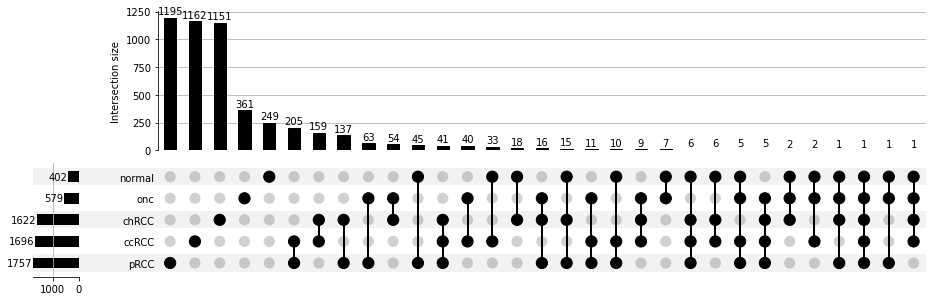

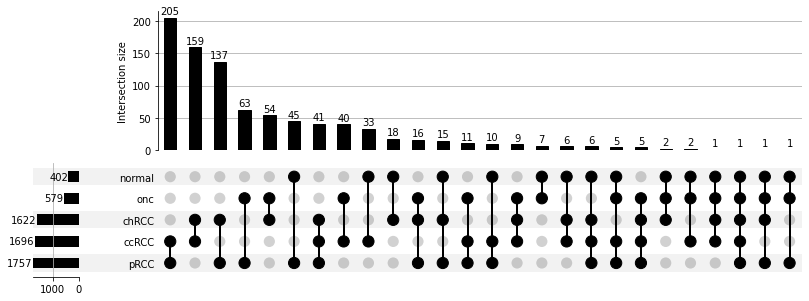

In [763]:
# plot all upset plots:

# need a 5-way upset plot (shows overlap between sets)
from upsetplot import from_contents
to_plot = from_contents({'normal': set(features_mapped_to_genes.query('`class` == 0')['ensembl_gene_id']), 
                         'ccRCC': set(features_mapped_to_genes.query('`class` == 1')['ensembl_gene_id']), 
                         'chRCC': set(features_mapped_to_genes.query('`class` == 2')['ensembl_gene_id']), 
                         'onc': set(features_mapped_to_genes.query('`class` == 3')['ensembl_gene_id']), 
                         'pRCC': set(features_mapped_to_genes.query('`class` == 4')['ensembl_gene_id'])})
to_plot[0:30]

from upsetplot import UpSet

# with single sets:    
plt = UpSet(to_plot, subset_size='count', sort_by='cardinality', show_counts=True).plot() # setting max_subset_size means single sets aren't plotted
# just intersections:
plt = UpSet(to_plot, subset_size='count', sort_by='cardinality', show_counts=True, max_subset_size=210).plot() # setting max_subset_size means single sets aren't plotted
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.savefig("features_per_class/gene_upset_plot.svg")
